In [7]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model

from sklearn.utils.class_weight import compute_class_weight

from matplotlib import pyplot as plt

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

pd.__version__: 2.2.3
tf.__version__: 2.15.1


In [8]:
dataset_dir = "../Dataset/machine-learning-in-science-ii-2025/test_data/test_data"

ds = tf.data.Dataset.list_files(
    os.path.join(dataset_dir, "*"), shuffle=False
)
image_count = len(ds)

for f in ds.take(5):
    print(f.numpy())

# Extract image IDs
def extract_image_id(file_path):
    file_path = file_path.numpy().decode("utf-8")  # Convert from bytes to string
    filename = os.path.basename(file_path)  # Extract "1.png", "10.png", etc.
    image_id = filename.split(".")[0]  # Extract "1", "10", "100"
    return image_id

image_id_list = []

for path in ds:
    image_id_list.append(extract_image_id(path))

image_id_list = np.array(image_id_list)

b'../Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1.png'
b'../Dataset/machine-learning-in-science-ii-2025/test_data/test_data/10.png'
b'../Dataset/machine-learning-in-science-ii-2025/test_data/test_data/100.png'
b'../Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1000.png'
b'../Dataset/machine-learning-in-science-ii-2025/test_data/test_data/1001.png'


In [9]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [10]:
ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

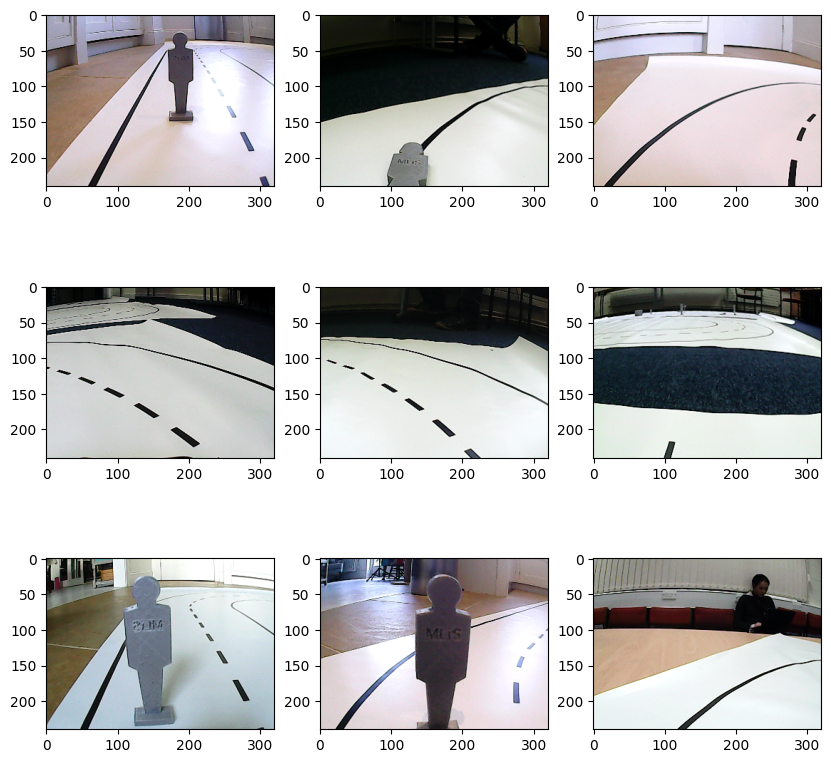

In [11]:
plt.figure(figsize=(10, 10))

i = 0

for image in ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    i += 1

In [12]:
def scale_ds(image):
    # Range of input image: [0, 1]
    return image * 2 - 1.0

def configure_for_performance(ds):
    ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds = ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
ds = configure_for_performance(ds)

In [13]:
model_paths = [
    "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/kaggle_submission/speed_model_20250310_1055_submission1/speed_model_20250310_1055.keras",
    "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/kaggle_submission/speed_model_20250310_1155_submission2/speed_model_20250310_1155.keras",
    "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/kaggle_submission/speed_model_20250310_1224_submission3/speed_model_20250310_1224.keras",
    "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/kaggle_submission/speed_model_20250310_1305_submission4/speed_model_20250310_1305.keras",
    "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/kaggle_submission/speed_model_20250310_1343_submission5/speed_model_20250310_1343.keras",
    "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/kaggle_submission/speed_model_20250310_1348_submission6/speed_model_20250310_1348.keras",
    "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/kaggle_submission/speed_model_20250310_1410_submission7/speed_model_20250310_1410.keras",
]

preds = []

for model_path in model_paths:
    print(f"Loading model {model_path.split('/')[-1]}")
    model = keras.models.load_model(
        model_path,
        custom_objects={
            "WeightedBinaryCrossEntropy": WeightedBinaryCrossEntropy,
            "WeightedMeanSquaredError": WeightedMeanSquaredError,
        },
    )
    preds.append(model.predict(ds))

Loading model speed_model_20250310_1055.keras


2025-03-25 22:51:20.782470: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-25 22:51:20.980449: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-25 22:51:21.711984: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1020/1020 [==============================] - 23s 19ms/step
Loading model speed_model_20250310_1155.keras
1020/1020 [==============================] - 14s 12ms/step
Loading model speed_model_20250310_1224.keras
1020/1020 [==============================] - 12s 11ms/step
Loading model speed_model_20250310_1305.keras
1020/1020 [==============================] - 13s 11ms/step
Loading model speed_model_20250310_1343.keras
1020/1020 [==============================] - 20s 19ms/step
Loading model speed_model_20250310_1348.keras
1020/1020 [==============================] - 15s 14ms/step
Loading model speed_model_20250310_1410.keras
1020/1020 [==============================] - 17s 16ms/step


In [78]:
preds_concat = []

for pred in preds:
    for p in pred.values():
        preds_concat.append(p[:, 0])

preds_concat = np.array(preds_concat)

mean_pred = np.mean(preds_concat, axis=0)

std_mean = np.std(preds_concat, axis=0)

In [92]:
mean_pred_filtered = []
for p in mean_pred:
    if np.abs(p-0.5) > 0.47:
        mean_pred_filtered.append(np.sign(p-0.5) * 0.5 + 0.5)
    else:
        mean_pred_filtered.append(p)

mean_pred_filtered = np.array(mean_pred_filtered)

# mean_pred = (mean_pred > 0.5).astype(int)

df = pd.DataFrame({
  'image_id': image_id_list.astype(int), 
  'speed': mean_pred_filtered,
  'std': std_mean
}).sort_values('image_id').set_index('image_id')

In [114]:
uncertain = df[(df['std'] > 0.05)].reset_index()
print(len(uncertain))

86


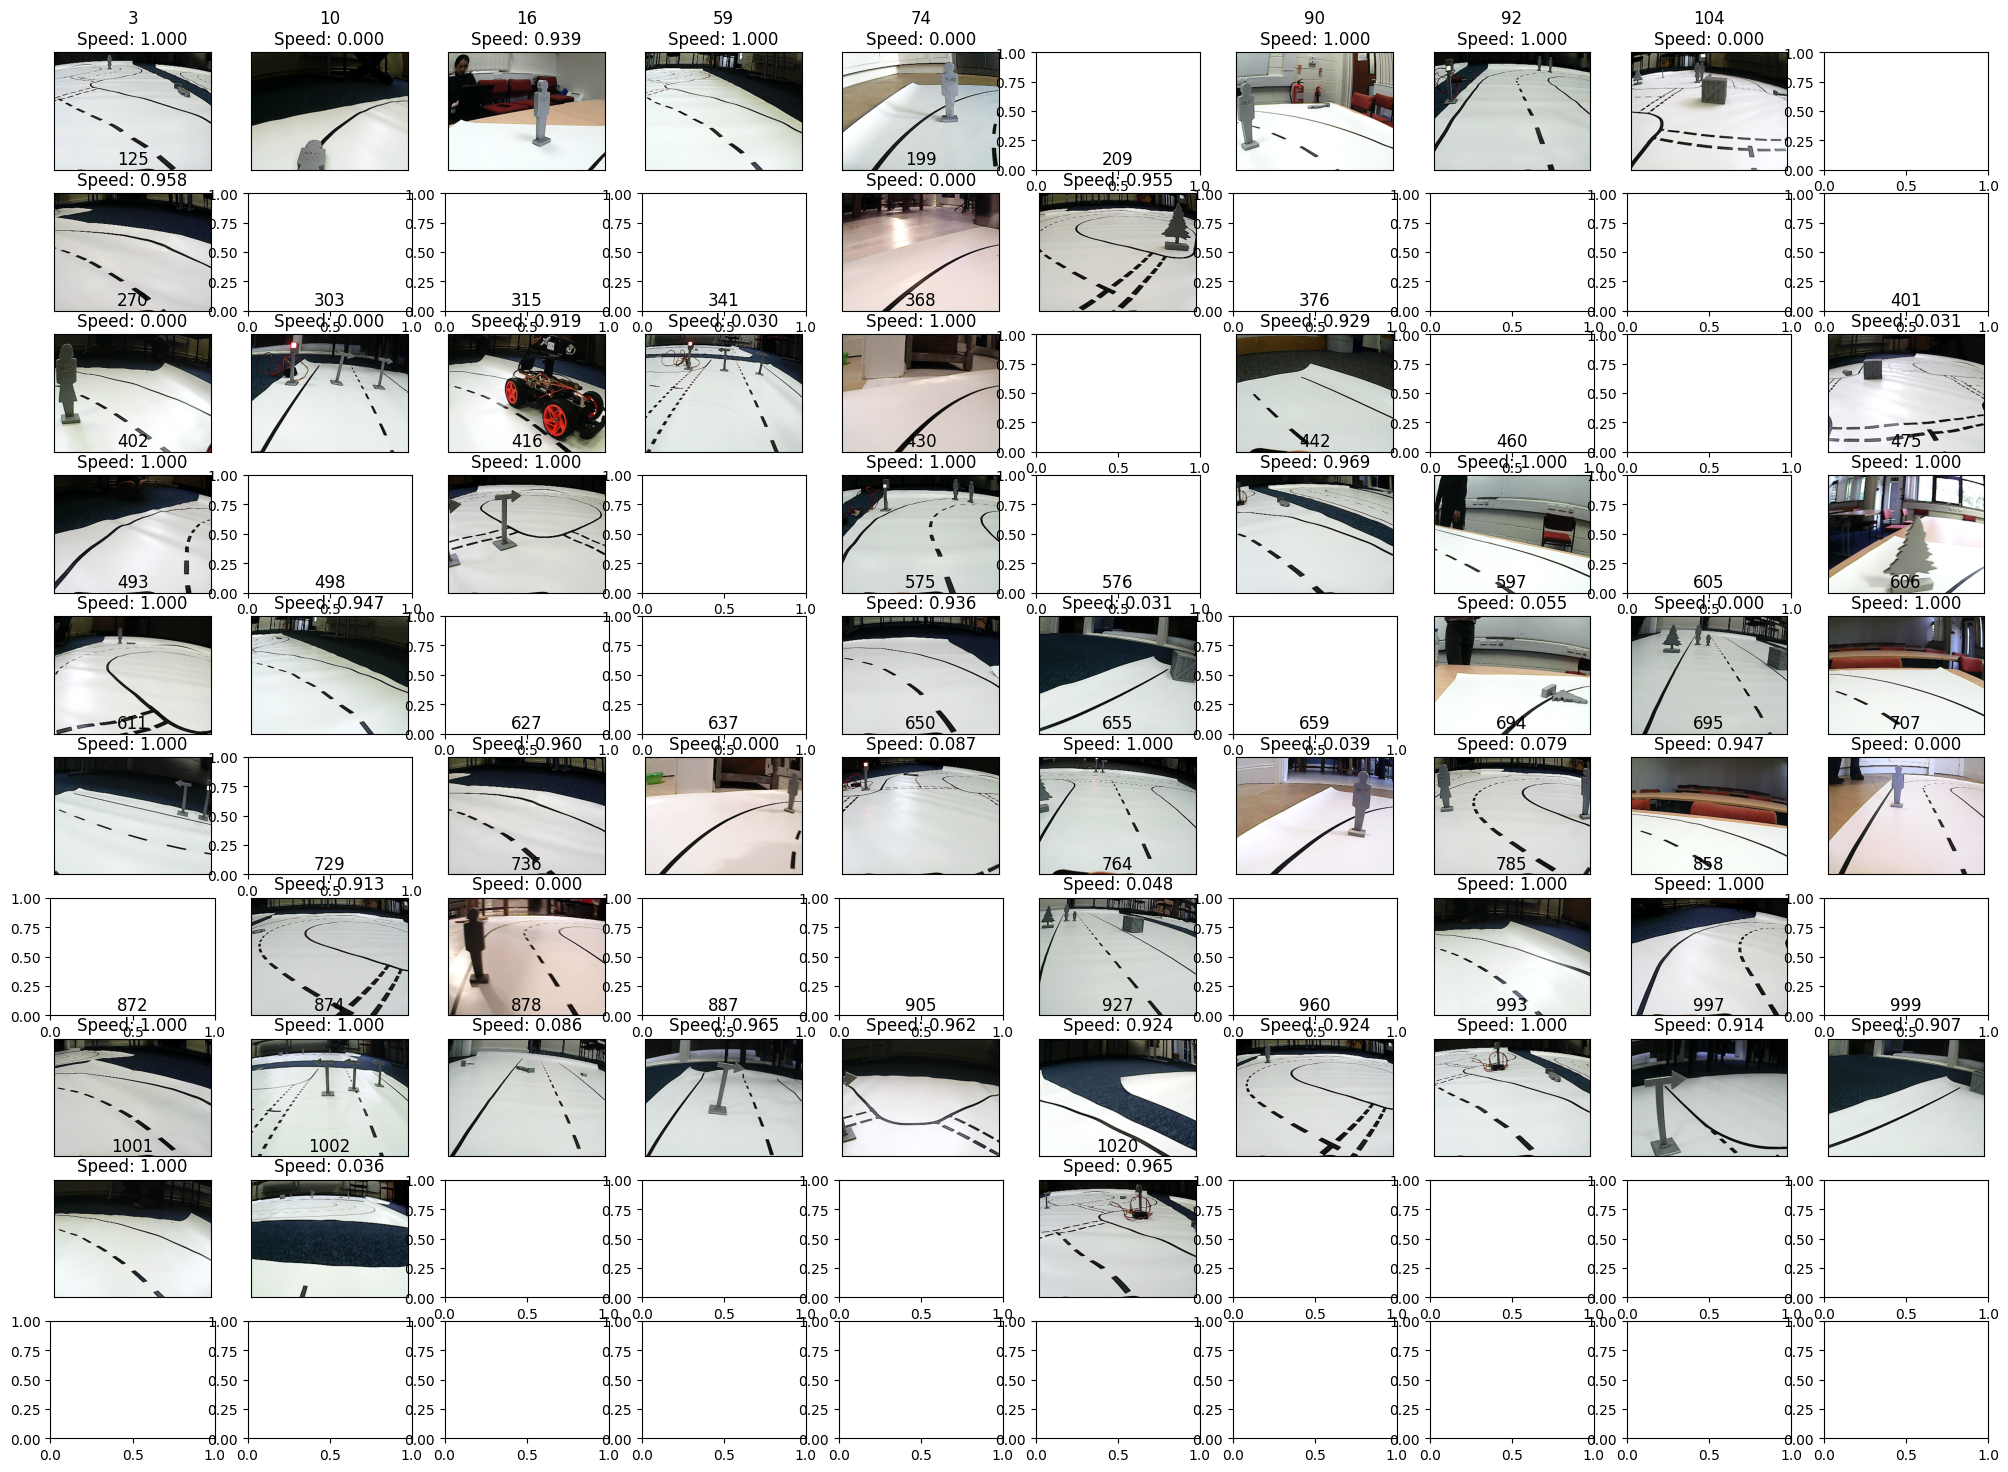

In [116]:
fig, ax = plt.subplots(10, 10, figsize=(25, 18))
ax = ax.ravel()

for i in uncertain.index:
    s = abs(uncertain.loc[i]['speed'] - 0.5)
    if s < 0.4:
        continue

    image_id = (int(uncertain.loc[i]['image_id']))
    image_path = f"/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025/test_data/test_data/{image_id}.png"
    image = Image.open(image_path)
    ax[i].imshow(image)
    ax[i].set_title(f"{image_id}\nSpeed: {uncertain.loc[i]['speed']:.3f}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [15]:
mean_pred_filtered = []
for p in mean_pred:
    if np.abs(p-0.5) > 0.4:
        mean_pred_filtered.append(np.sign(p-0.5) * 0.5 + 0.5)
    else:
        mean_pred_filtered.append(p)

mean_pred_filtered = np.array(mean_pred_filtered)

mean_pred = (mean_pred > 0.5).astype(int)

np.unique(mean_pred_filtered, return_counts=True)

(array([0.        , 0.17023073, 0.24397528, 0.26276791, 0.42984244,
        0.43590811, 0.43618166, 0.45335123, 0.47168437, 0.48578367,
        0.55326337, 0.60942721, 0.61376661, 0.62581611, 0.62629122,
        0.65783638, 0.67290574, 0.70206922, 0.71002901, 0.71417207,
        0.74759245, 0.77714086, 0.81383449, 0.81599844, 0.83257556,
        0.83611459, 0.83857071, 0.87474257, 0.88126379, 1.        ]),
 array([505,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1, 487]))

In [16]:
df = pd.DataFrame({
  'image_id': image_id_list.astype(int), 
  'speed': mean_pred_filtered,
})
df

image_id  speed
0            1    0.0
1           10    0.0
2          100    1.0
3         1000    1.0
4         1001    1.0
...        ...    ...
1015       995    0.0
1016       996    0.0
1017       997    1.0
1018       998    0.0
1019       999    1.0

[1020 rows x 2 columns]

In [17]:
df = df.sort_values('image_id')
df

image_id     speed
0           1  0.000000
132         2  1.000000
243         3  1.000000
354         4  1.000000
465         5  1.000000
..        ...       ...
20       1016  0.613767
21       1017  0.000000
22       1018  1.000000
23       1019  1.000000
25       1020  1.000000

[1020 rows x 2 columns]

28


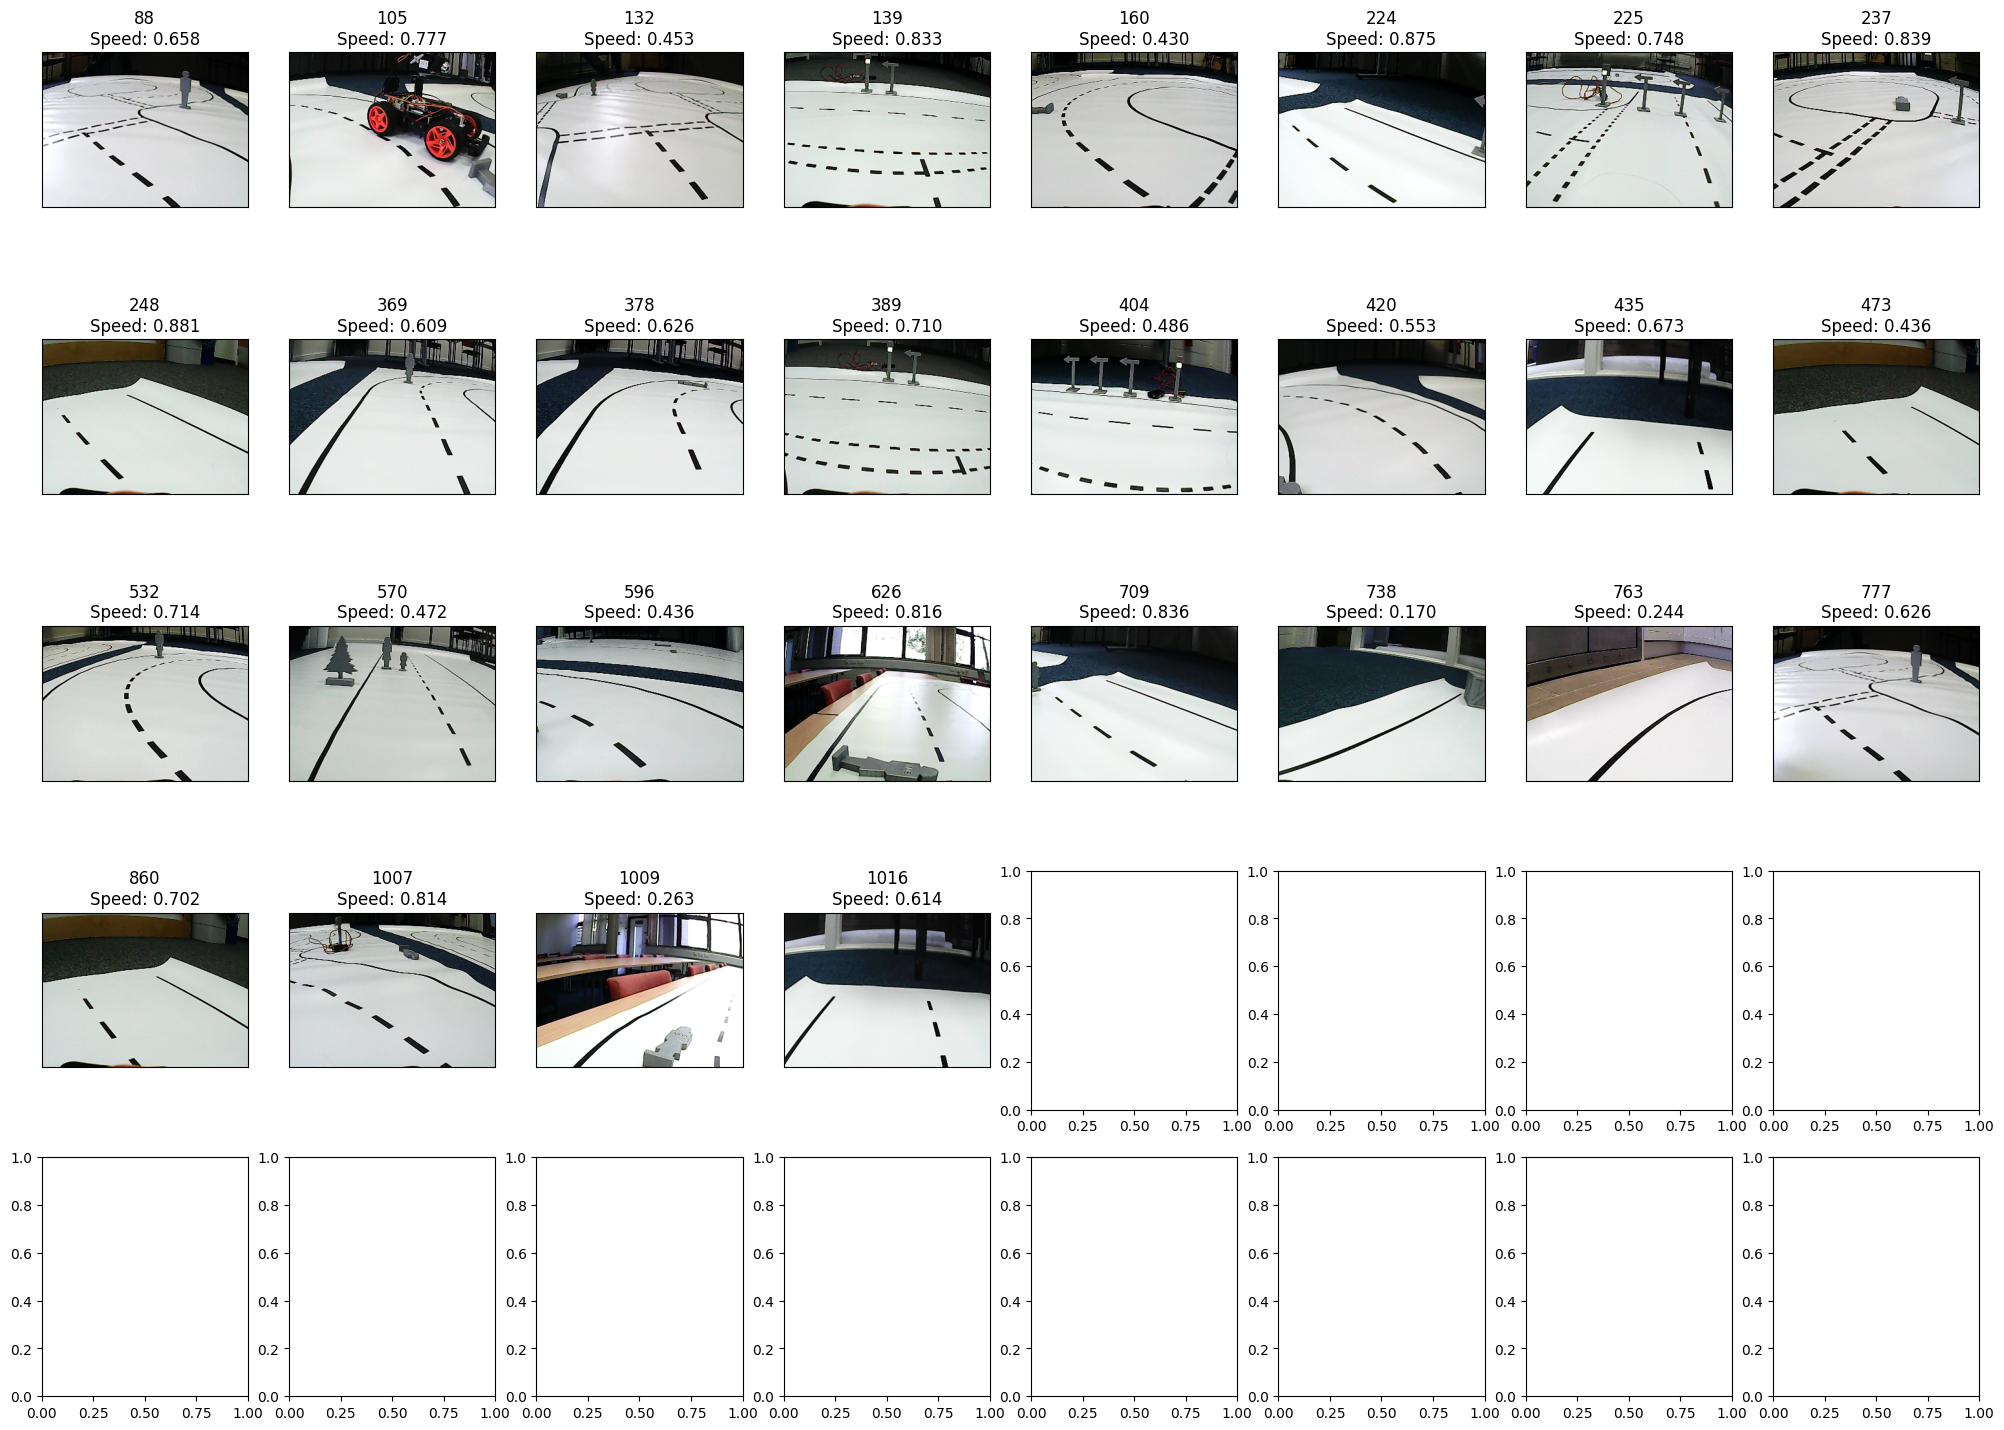

In [18]:
not_confident = df[(df['speed'] != 1) & (df['speed'] != 0)].reset_index(drop=True)
# not_confident = df[(np.abs(df['speed'] - 0.5) > 0.4) & (np.abs(df['speed'] - 0.5) < 0.45)].reset_index(drop=True)
print(len(not_confident))

fig, ax = plt.subplots(5, 8, figsize=(25, 18))
ax = ax.ravel()

# print(not_confident)


for i in not_confident.index:
    image_id = (int(not_confident.loc[i]['image_id']))
    image_path = f"/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025/test_data/test_data/{image_id}.png"
    image = Image.open(image_path)
    ax[i].imshow(image)
    ax[i].set_title(f"{image_id}\nSpeed: {not_confident.loc[i]['speed']:.3f}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [19]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
# df.to_csv(f'prediction_speed_{timestamp}.csv', index=False)

In [20]:
# image_id_list

# y_pred = []
# for key in pred.keys():
#     y_pred.append(pred[key][:, 0])

# y_pred = np.array(y_pred)

# y_pred = np.array(y_pred).T

# y_pred = y_pred-0.5

# y_pred[0]

# def y_pred_map(y_pred):
#     if abs(np.mean(y_pred)) > 0.4:
#         return np.sign(np.mean(y_pred)) * 0.5 + 0.5
#     else:
#         return np.mean(y_pred)+0.5


# y_pred_2 = []

# for i in range(len(y_pred)):
#     y_pred_2.append(y_pred_map(y_pred[i]))


# y_pred_mean =(np.mean(y_pred, axis=1)>0).astype(int)

# # speed_pred = output['speed_output'][:, 0]

# # speed_pred = speed_pred > 0.5

# # speed_pred = np.array(speed_pred).astype(int)

# # print(speed_pred)
# # print(image_id_list)

In [21]:
# df = pd.DataFrame({
#   'image_id': image_id_list.astype(int), 
#   'speed': y_pred_2,
# })
# df

In [22]:
# timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
# df.to_csv(f'prediction_speed_{timestamp}.csv', index=False)

In [23]:
# np.sum(np.array(y_pred_2)>0.5) / len(y_pred_2)